In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Read the CSV file
df = pd.read_csv('project step 2.csv')

# Assuming 'PRICE' is the target variable
target_variable = 'PRICE'

# Extract features and target variable
X = df.drop(target_variable, axis=1)
y = df[target_variable]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize base models
rf_base_model = RandomForestRegressor(n_estimators=100, random_state=42)
lgbm_base_model = LGBMRegressor(n_estimators=100, random_state=42)

# Create an array to store base model predictions for each fold
base_model_predictions = np.zeros((X_train.shape[0], 2))

# Initialize meta-model
xgb_meta_model = XGBRegressor(n_estimators=100, random_state=42)

# Create KFold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform 2-level stacking with cross-validation
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Train base models on the current fold
    rf_base_model.fit(X_train_fold, y_train_fold)
    lgbm_base_model.fit(X_train_fold, y_train_fold)

    # Make predictions on the validation set for base models
    base_model_predictions[val_index, 0] = rf_base_model.predict(X_val_fold)
    base_model_predictions[val_index, 1] = lgbm_base_model.predict(X_val_fold)

# Train the meta-model on base model predictions
xgb_meta_model.fit(base_model_predictions, y_train)

# Make predictions on the test set for base models
rf_test_pred = rf_base_model.predict(X_test)
lgbm_test_pred = lgbm_base_model.predict(X_test)

# Combine predictions for the test set as input to the meta-model
meta_model_input = np.column_stack((rf_test_pred, lgbm_test_pred))

# Make final predictions using the meta-model
final_pred = xgb_meta_model.predict(meta_model_input)

# Calculate metrics for the stacked model
rmse = np.sqrt(mean_squared_error(y_test, final_pred))
rae = mean_absolute_error(y_test, final_pred)
mape = np.mean(np.abs((y_test - final_pred) / y_test)) * 100
rmsle = np.sqrt(np.mean(np.power(np.log1p(y_test) - np.log1p(final_pred), 2)))

# Print the results
print("Root Mean Squared Error (RMSE): {:.2f}".format(rmse))
print("Relative Absolute Error (RAE): {:.2f}".format(rae))
print("Mean Absolute Percentage Error (MAPE): {:.2f}%".format(mape))
print("Root Mean Squared Logarithmic Error (RMSLE): {:.2f}".format(rmsle))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 538
[LightGBM] [Info] Number of data points in the train set: 4494, number of used features: 27
[LightGBM] [Info] Start training from score 89468.459279
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 539
[LightGBM] [Info] Number of data points in the train set: 4494, number of used features: 27
[LightGBM] [Info] Start training from score 88299.647530
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

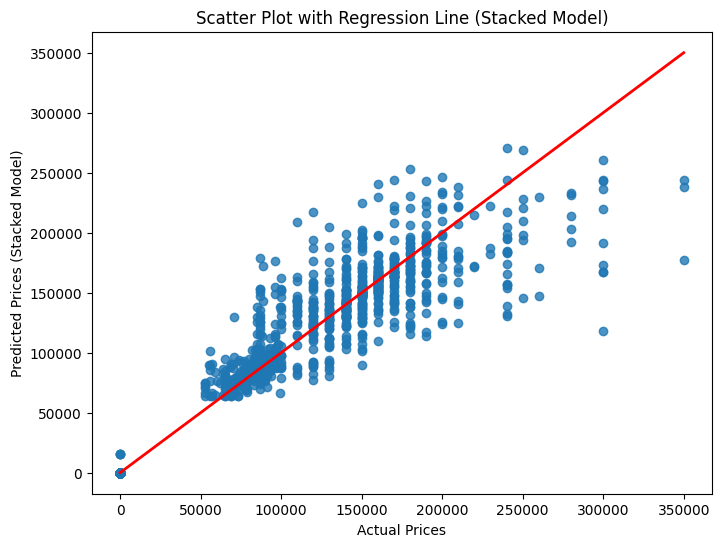

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, final_pred, alpha=0.8)  # Plot actual vs. stacked model's predicted values
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)  # Add regression line
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices (Stacked Model)")
plt.title("Scatter Plot with Regression Line (Stacked Model)")
plt.show()


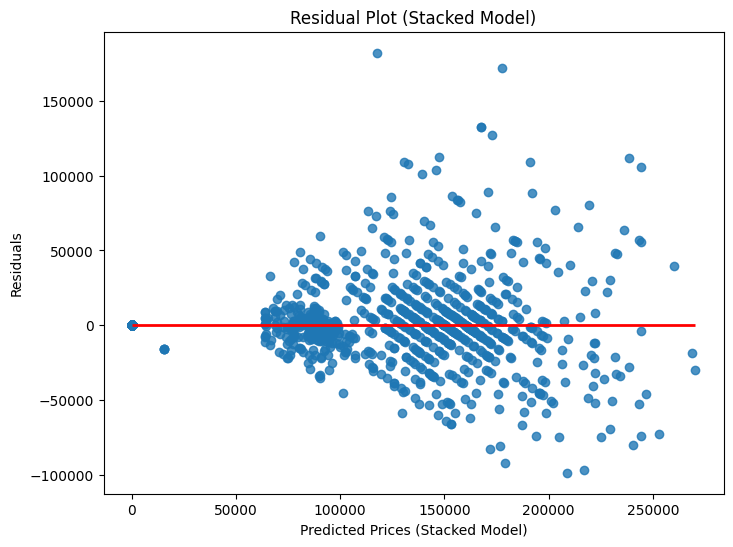

In [3]:
residuals = y_test - final_pred
plt.figure(figsize=(8, 6))
plt.scatter(final_pred, residuals, alpha=0.8)  # Plot residuals vs. stacked model's predicted values
plt.xlabel("Predicted Prices (Stacked Model)")
plt.ylabel("Residuals")
plt.title("Residual Plot (Stacked Model)")
plt.hlines(0, final_pred.min(), final_pred.max(), color='red', linewidth=2)  # Add horizontal line at zero
plt.show()


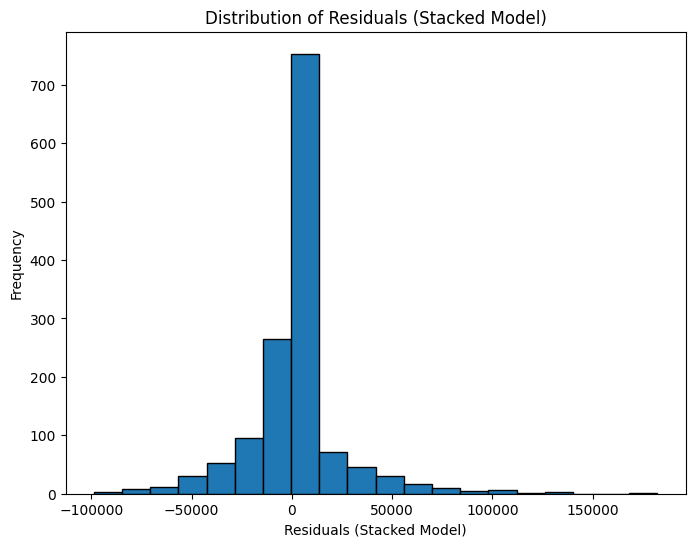

In [4]:
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=20, edgecolor='black')  # Plot histogram of residuals
plt.xlabel("Residuals (Stacked Model)")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals (Stacked Model)")
plt.show()
